# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

from torchmetrics import Precision, Recall, F1Score

import seaborn as sns
import collections

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9

#scheduler
STEP=5 
GAMMA=0.5

### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()


In [6]:
model = ConvNet()
model.to(device)

### Optimizer

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

### Definition of Focal Loss 

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        pt = torch.exp(-ce_loss) 
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        return torch.mean(focal_loss)

In [9]:
def train_batch(model, image, target, criterion):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

## decorator function for some loss functions
def decorator(func):
    def wrapper(model, image, target,criterion):
        target = F.one_hot(target,num_classes = 10).float()
        result = func(model, image, target,criterion)
        return result
    return wrapper

In [10]:

def test_batch(model, image, target, criterion):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

## decorator function for some loss functions
def decorator(func):
    def wrapper(model, image, target,criterion):
        target = F.one_hot(target,num_classes = 10).float()
        result = func(model, image, target,criterion)
        return result
    return wrapper

### Model Training
Here we caculate precision, recall, F1 by torchmetric instead of sklearn

In [11]:
def Model_Training(train_batch, test_batch, criterion):
    
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
    
    training_loss = []
    training_acc = []
    training_precision = []
    training_recall = []
    training_f1 = []


    testing_loss = []
    testing_acc = []
    testing_precision = []
    testing_recall = []
    testing_f1 = []

    training_precision_metric = Precision(task="multiclass", num_classes=10, average='macro').to(device)
    training_recall_metric = Recall(task="multiclass", num_classes=10, average='macro').to(device)
    training_f1_metric = F1Score(task="multiclass", num_classes=10, average='macro').to(device)
    
    testing_precision_metric = Precision(task="multiclass", num_classes=10, average='macro').to(device)
    testing_recall_metric = Recall(task="multiclass", num_classes=10, average='macro').to(device)
    testing_f1_metric = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0
        training_precision_metric.reset()
        training_recall_metric.reset()
        training_f1_metric.reset()

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target, criterion)
            _, preds = torch.max(outputs, 1)


            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
                
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)
            training_precision_metric.update(preds, target)
            training_recall_metric.update(preds, target)
            training_f1_metric.update(preds, target)


            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)
        epoch_precision = training_precision_metric.compute()
        epoch_recall = training_recall_metric.compute()
        epoch_f1 = training_f1_metric.compute()

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1:{epoch_f1:.4f}')

        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc.cpu().detach().numpy())
        training_precision.append(epoch_precision.cpu().detach().numpy())
        training_recall.append(epoch_recall.cpu().detach().numpy())
        training_f1.append(epoch_f1.cpu().detach().numpy())

        # change learning rate
        scheduler.step()


        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0
            testing_precision_metric.reset()
            testing_recall_metric.reset()
            testing_f1_metric.reset()

            for batch_idx, (image, target) in enumerate(test_dataloader):

                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target, criterion)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)
                testing_precision_metric.update(preds, target)
                testing_recall_metric.update(preds, target)
                testing_f1_metric.update(preds, target)

            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            val_precision = testing_precision_metric.compute()
            val_recall = testing_recall_metric.compute()
            val_f1 = testing_f1_metric.compute()
            
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1:{val_f1:.4f}')
            testing_loss.append(val_loss)
            testing_acc.append(val_acc.cpu().detach().numpy())
            testing_precision.append(val_precision.cpu().detach().numpy())
            testing_recall.append(val_recall.cpu().detach().numpy())
            testing_f1.append(val_f1.cpu().detach().numpy())

            # save the model in last epoch
            if (epoch +1) == NUM_EPOCHS:

                state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc,
                'epoch': (epoch+1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
    
    #reset all for next training
    model.reset_parameters()

    return training_acc, training_loss, training_precision, training_recall, training_f1, testing_loss, testing_acc, testing_precision, testing_recall, testing_f1

### CrossEntropyLoss

In [42]:
CE_training_acc, CE_training_loss, CE_training_precision, CE_training_recall, CE_training_f1, CE_testing_loss, CE_testing_acc, CE_testing_precision, CE_testing_recall, CE_testing_f1 = Model_Training(train_batch, test_batch, nn.CrossEntropyLoss())

Epoch: 1/30 Train Loss: 0.0155 Acc: 0.2627 Precision: 0.2601 Recall: 0.2627 F1:0.2552
Begin test......
Test Loss: 0.0147 Acc: 0.3129 Precision: 0.3412 Recall: 0.3129 F1:0.2813
Epoch: 2/30 Train Loss: 0.0142 Acc: 0.3205 Precision: 0.3128 Recall: 0.3205 F1:0.3112
Begin test......
Test Loss: 0.0130 Acc: 0.3870 Precision: 0.3790 Recall: 0.3870 F1:0.3689
Epoch: 3/30 Train Loss: 0.0139 Acc: 0.3420 Precision: 0.3340 Recall: 0.3420 F1:0.3324
Begin test......
Test Loss: 0.0130 Acc: 0.3728 Precision: 0.3855 Recall: 0.3728 F1:0.3583
Epoch: 4/30 Train Loss: 0.0138 Acc: 0.3459 Precision: 0.3369 Recall: 0.3459 F1:0.3361
Begin test......
Test Loss: 0.0130 Acc: 0.3923 Precision: 0.4204 Recall: 0.3923 F1:0.3689
Epoch: 5/30 Train Loss: 0.0138 Acc: 0.3467 Precision: 0.3387 Recall: 0.3467 F1:0.3375
Begin test......
Test Loss: 0.0135 Acc: 0.3544 Precision: 0.3766 Recall: 0.3544 F1:0.3250
Epoch: 6/30 Train Loss: 0.0131 Acc: 0.3765 Precision: 0.3679 Recall: 0.3765 F1:0.3683
Begin test......
Test Loss: 0.0127

### L1 Loss

In [15]:
L1_training_acc, L1_training_loss, L1_training_precision, L1_training_recall, L1_training_f1, L1_testing_loss, L1_testing_acc, L1_testing_precision, L1_testing_recall,L1_testing_f1 = Model_Training(decorator(train_batch), decorator(test_batch), nn.L1Loss())

Epoch: 1/30 Train Loss: 0.0009 Acc: 0.0997 Precision: 0.1002 Recall: 0.0997 F1:0.0985
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 Recall: 0.1000 F1:0.0182
Epoch: 2/30 Train Loss: 0.0009 Acc: 0.1013 Precision: 0.1012 Recall: 0.1013 F1:0.1006
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 Recall: 0.1000 F1:0.0182
Epoch: 3/30 Train Loss: 0.0009 Acc: 0.1008 Precision: 0.1005 Recall: 0.1008 F1:0.0987
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 Recall: 0.1000 F1:0.0182
Epoch: 4/30 Train Loss: 0.0009 Acc: 0.1023 Precision: 0.1019 Recall: 0.1023 F1:0.0994
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 Recall: 0.1000 F1:0.0182
Epoch: 5/30 Train Loss: 0.0009 Acc: 0.0993 Precision: 0.1002 Recall: 0.0993 F1:0.0973
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 Recall: 0.1000 F1:0.0182
Epoch: 6/30 Train Loss: 0.0008 Acc: 0.1003 Precision: 0.1008 Recall: 0.1003 F1:0.0962
Begin test......
Test Loss: 0.0008

### Focal($\gamma = .5$)

In [13]:
Focal_training_acc, Focal_training_loss, Focal_training_precision, Focal_training_recall, Focal_training_f1, Focal_testing_loss, Focal_testing_acc, Focal_testing_precision, Focal_testing_recall, Focal_testing_f1 = Model_Training(decorator(train_batch), decorator(test_batch), FocalLoss(gamma = 0.5))

Epoch: 1/30 Train Loss: 0.0165 Acc: 0.1453 Precision: 0.1473 Recall: 0.1453 F1:0.1386
Begin test......
Test Loss: 0.0160 Acc: 0.1700 Precision: 0.1048 Recall: 0.1700 F1:0.0925
Epoch: 2/30 Train Loss: 0.0156 Acc: 0.1755 Precision: 0.1674 Recall: 0.1755 F1:0.1484
Begin test......
Test Loss: 0.0154 Acc: 0.2070 Precision: 0.1473 Recall: 0.2070 F1:0.1253
Epoch: 3/30 Train Loss: 0.0146 Acc: 0.2129 Precision: 0.2080 Recall: 0.2129 F1:0.1985
Begin test......
Test Loss: 0.0133 Acc: 0.2867 Precision: 0.2821 Recall: 0.2867 F1:0.2478
Epoch: 4/30 Train Loss: 0.0135 Acc: 0.2798 Precision: 0.2724 Recall: 0.2798 F1:0.2718
Begin test......
Test Loss: 0.0125 Acc: 0.3413 Precision: 0.3474 Recall: 0.3413 F1:0.3037
Epoch: 5/30 Train Loss: 0.0132 Acc: 0.3032 Precision: 0.2973 Recall: 0.3032 F1:0.2967
Begin test......
Test Loss: 0.0127 Acc: 0.3166 Precision: 0.3439 Recall: 0.3166 F1:0.2808
Epoch: 6/30 Train Loss: 0.0123 Acc: 0.3442 Precision: 0.3375 Recall: 0.3442 F1:0.3374
Begin test......
Test Loss: 0.0116

### Focal($\gamma = 2$)

In [14]:
Focal2_training_acc, Focal2_training_loss, Focal2_training_precision, Focal2_training_recall, Focal2_training_f1, Focal2_testing_loss, Focal2_testing_acc, Focal2_testing_precision, Focal2_testing_recall, Focal2_testing_f1 = Model_Training(decorator(train_batch), decorator(test_batch), FocalLoss(gamma = 2))

Epoch: 1/30 Train Loss: 0.0116 Acc: 0.2503 Precision: 0.2479 Recall: 0.2503 F1:0.2478
Begin test......
Test Loss: 0.0098 Acc: 0.3392 Precision: 0.3517 Recall: 0.3392 F1:0.3221
Epoch: 2/30 Train Loss: 0.0105 Acc: 0.3064 Precision: 0.3033 Recall: 0.3064 F1:0.3026
Begin test......
Test Loss: 0.0102 Acc: 0.3314 Precision: 0.3579 Recall: 0.3314 F1:0.3094
Epoch: 3/30 Train Loss: 0.0103 Acc: 0.3201 Precision: 0.3195 Recall: 0.3201 F1:0.3163
Begin test......
Test Loss: 0.0100 Acc: 0.3189 Precision: 0.3366 Recall: 0.3189 F1:0.3022
Epoch: 4/30 Train Loss: 0.0100 Acc: 0.3270 Precision: 0.3256 Recall: 0.3270 F1:0.3241
Begin test......
Test Loss: 0.0093 Acc: 0.3724 Precision: 0.3834 Recall: 0.3724 F1:0.3550
Epoch: 5/30 Train Loss: 0.0098 Acc: 0.3413 Precision: 0.3409 Recall: 0.3413 F1:0.3390
Begin test......
Test Loss: 0.0094 Acc: 0.3654 Precision: 0.3682 Recall: 0.3654 F1:0.3436
Epoch: 6/30 Train Loss: 0.0090 Acc: 0.3774 Precision: 0.3764 Recall: 0.3774 F1:0.3749
Begin test......
Test Loss: 0.0083

### Plot

In [35]:
def plot(CE_train, L1_train, Focal_train, Focal2_train, CE_test, L1_test, Focal_test, Focal2_test, metric):
    sns.set_theme()
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, NUM_EPOCHS + 1), CE_train, label='CE', color='blue')
    plt.plot(range(1, NUM_EPOCHS + 1), L1_train, label='L1', color='orange')
    plt.plot(range(1, NUM_EPOCHS + 1), Focal_train, label='Focal0.5', color='green')
    plt.plot(range(1, NUM_EPOCHS + 1), Focal2_train, label='Focal2', color='purple')
    
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title('Training' + metric)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, NUM_EPOCHS + 1), CE_test, label='CE', color='blue')
    plt.plot(range(1, NUM_EPOCHS + 1), L1_test, label='L1', color='orange')
    plt.plot(range(1, NUM_EPOCHS + 1), Focal_test, label='Focal0.5', color='green')
    plt.plot(range(1, NUM_EPOCHS + 1), Focal2_test, label='Focal2', color='purple')
    
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title('Testing' + metric)

    plt.tight_layout()
    plt.show()

### Loss Plot

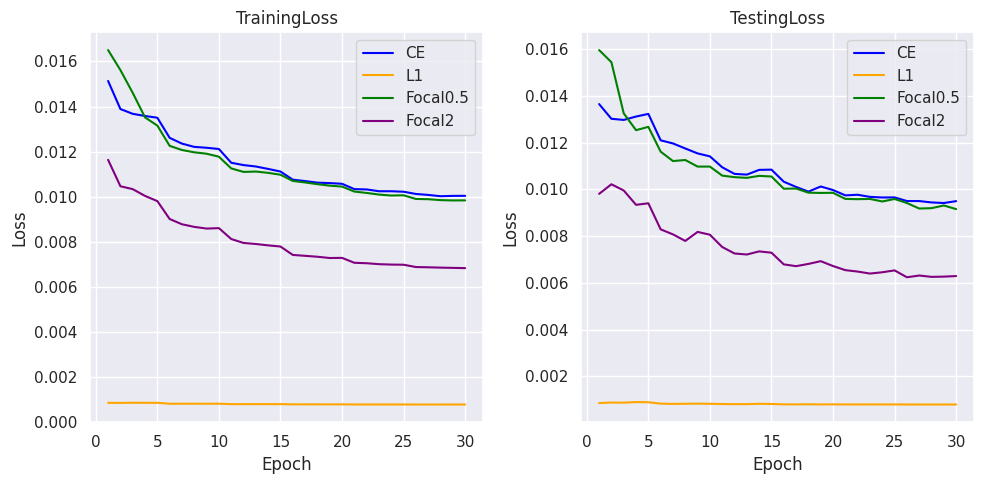

In [36]:
plot(CE_training_loss,L1_training_loss,Focal_training_loss,Focal2_training_loss,CE_testing_loss,L1_testing_loss,Focal_testing_loss,Focal2_testing_loss,'Loss')

### Accuracy Plot

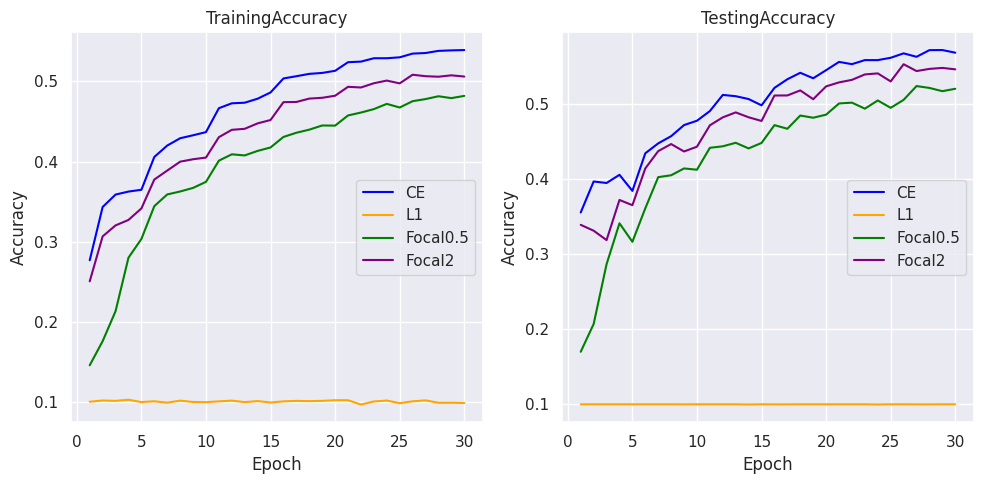

In [37]:
plot(CE_training_acc,L1_training_acc,Focal_training_acc,Focal2_training_acc,CE_testing_acc,L1_testing_acc,Focal_testing_acc,Focal2_testing_acc,'Accuracy')

### Precision Plot

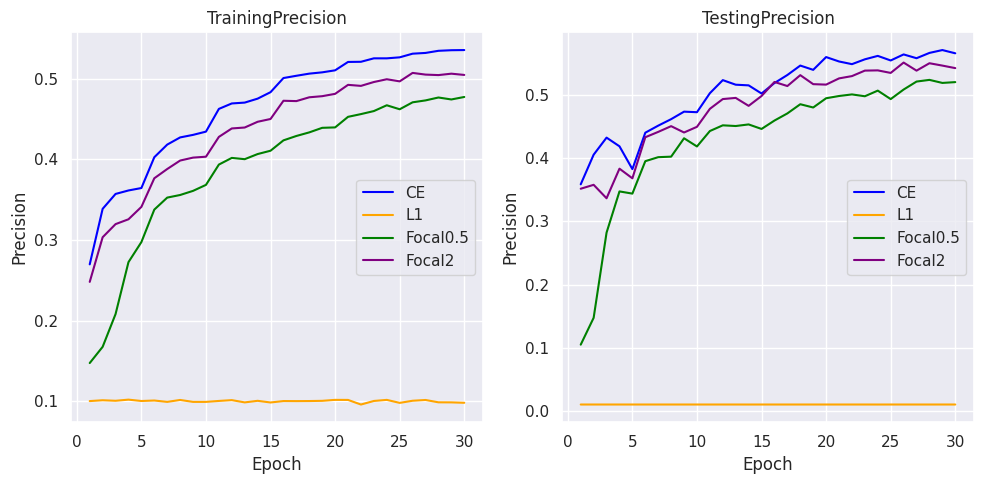

In [38]:
plot(CE_training_precision,L1_training_precision,Focal_training_precision,Focal2_training_precision,CE_testing_precision,L1_testing_precision,Focal_testing_precision,Focal2_testing_precision,'Precision')

### Recall Plot 

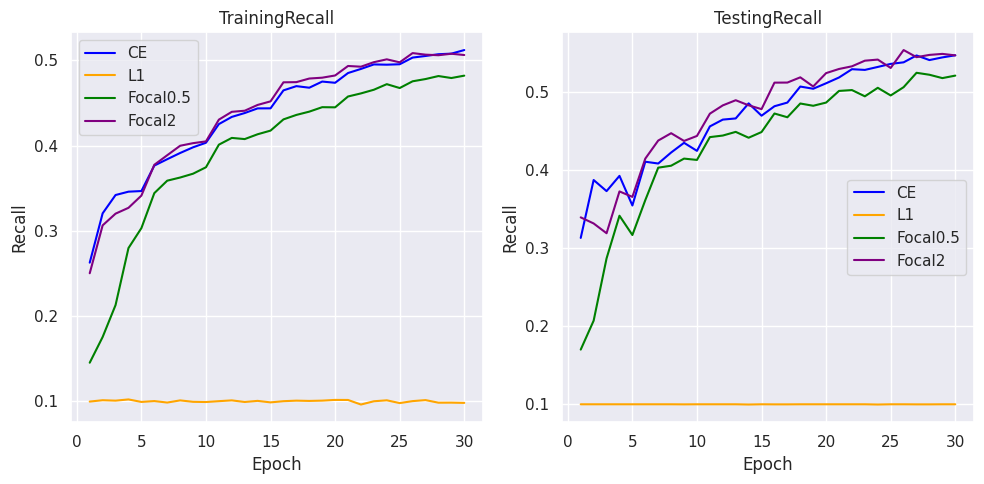

In [45]:
plot(CE_training_recall,L1_training_recall,Focal_training_recall,Focal2_training_recall,CE_testing_recall,L1_testing_recall,Focal_testing_recall,Focal2_testing_recall,'Recall')

### F1 Score Plot

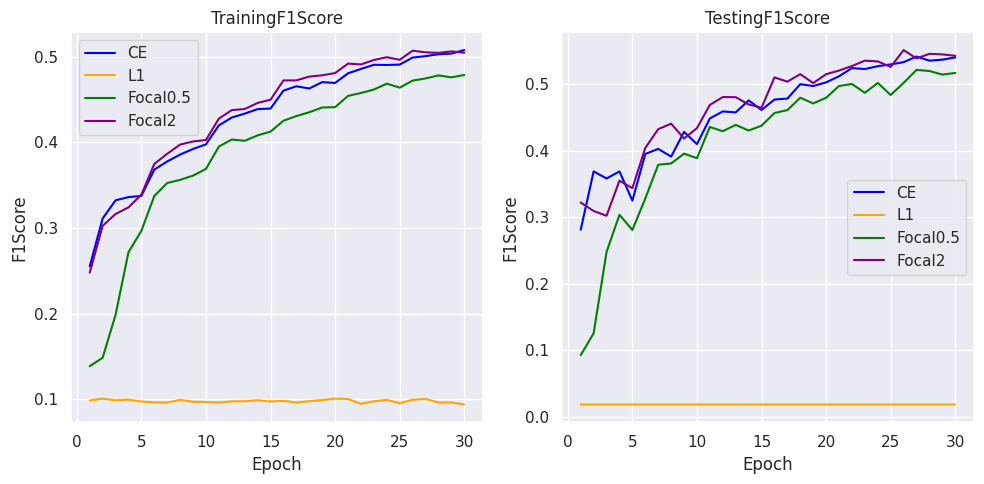

In [46]:
plot(CE_training_f1,L1_training_f1,Focal_training_f1,Focal2_training_f1,CE_testing_f1,L1_testing_f1,Focal_testing_f1,Focal2_testing_f1,'F1Score')

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [ ]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]
input_gpu = input.to(device)

In [ ]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
outputs = model(input_gpu)
probabilities = F.softmax(outputs, dim = 1)
_, predict_label = torch.max(probabilities, dim = 1)
probabilities = probabilities[0]

In [ ]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')